In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)
input_steps = 6   
output_steps = 6   


In [18]:
data_file = "data_readed.xlsx"
df = pd.read_excel(data_file)
print("DataFrame head:")
print(df.head())

# Xác định 10 features làm đầu vào (giả sử nằm ở cột thứ 4 đến 13)
features = df.columns[3:13].tolist()  
target_label = 'AWS'

# Chuyển đổi cột datetime và thêm các cột tuần, tháng, năm
df['datetime'] = pd.to_datetime(df['datetime'])
df['week'] = df['datetime'].dt.isocalendar().week
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df = df.sort_values(by='datetime').reset_index(drop=True)

# Điền giá trị thiếu cho các features
df[features] = df[features].fillna(method='ffill')

# Chuẩn hóa min-max cho các features đầu vào (không áp dụng cho target)
for col in features:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)

print("Features và target sau khi chuẩn hóa theo min-max:")
print(df[features + [target_label]].head())


DataFrame head:
   row  col            datetime  AWS    CAPE          CIN        EWSS  \
0    0  104 2020-10-01 00:00:00  0.0  197.25    61.953484 -113.054688   
1    0  104 2020-10-01 01:00:00  0.0  138.50  9999.000000 -128.285156   
2    0  104 2020-10-01 02:00:00  0.0  102.00  9999.000000 -120.671875   
3    0  104 2020-10-01 03:00:00  0.0  160.75  9999.000000 -169.191406   
4    0  104 2020-10-01 04:00:00  0.0  204.50   213.468903 -304.347656   

         IE      ISOR         KX  ...    SLHF      SLOR    SSHF      TCLW  \
0 -0.000017  0.676296  36.621414  ...  -59037  0.023543  -27549  0.373413   
1 -0.000038  0.676296  36.078514  ... -203202  0.023543  -64968  0.274780   
2 -0.000055  0.676296  35.410492  ... -376145  0.023543  -81566  0.194763   
3 -0.000064  0.676296  34.843140  ... -609080  0.023543 -101141  0.187439   
4 -0.000112  0.676296  34.893394  ... -654851  0.023543  -97831  0.104156   

         TCW       TCWV      U250      U850      V250      V850  
0  59.393524  59

C:\Users\giakh\AppData\Local\Temp\ipykernel_20060\3253527514.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features] = df[features].fillna(method='ffill')


In [19]:
def create_dataset(df, features, target_label, past=6, future=6):
    X, y = [], []
    feature_values = df[features].values
    target_values = df[target_label].values
    for i in range(len(df) - past - future + 1):
        X.append(feature_values[i:(i+past)])
        y.append(target_values[i+past:i+past+future])
    return np.array(X), np.array(y)

X, y = create_dataset(df, features, target_label, input_steps, output_steps)
print("Dataset shape:", X.shape, y.shape)

# Chia dữ liệu thành tập train và test (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Dataset shape: (657670, 6, 10) (657670, 6)


In [20]:
def create_model(input_shape, output_steps):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(output_steps))
    model.compile(optimizer='adam', loss='mse')
    return model

# In summary của một model mẫu để kiểm tra
sample_model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_steps=output_steps)
sample_model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,590 (76.52 KB)

 Trainable params: 19,590 (76.52 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_mse = []
cv_r2 = []
fold = 1

for train_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    
    # Tạo model mới cho mỗi fold
    model_cv = create_model(input_shape=(X_tr.shape[1], X_tr.shape[2]), output_steps=output_steps)
    history_cv = model_cv.fit(X_tr, y_tr, epochs=50, batch_size=32,
                              validation_data=(X_val, y_val), verbose=0)
    
    # Dự đoán và tính các chỉ số trên tập validation của fold này
    y_val_pred = model_cv.predict(X_val)
    mse_fold = mean_squared_error(y_val.flatten(), y_val_pred.flatten())
    r2_fold = r2_score(y_val.flatten(), y_val_pred.flatten())
    cv_mse.append(mse_fold)
    cv_r2.append(r2_fold)
    
    print(f"Fold {fold}: MSE = {mse_fold:.4f}, R2 = {r2_fold:.4f}")
    fold += 1

print("CV Average MSE:", np.mean(cv_mse))
print("CV Average R2:", np.mean(cv_r2))


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 1: MSE = 0.0002, R2 = -0.0177


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 2: MSE = 0.0003, R2 = -0.0253


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 3: MSE = 0.0001, R2 = -0.0097


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Fold 4: MSE = 0.0001, R2 = -0.0022


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 5: MSE = 0.0003, R2 = -0.0302
CV Average MSE: 0.00019842335238120793
CV Average R2: -0.01702054456990858


In [22]:
final_model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_steps=output_steps)
history = final_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
final_model.save('rain_prediction_model_v2.h5')


Epoch 1/100


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6577/6577 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 2.3753e-04 - val_loss: 2.1162e-04
Epoch 2/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0274e-04 - val_loss: 2.0957e-04
Epoch 3/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0143e-04 - val_loss: 2.1075e-04
Epoch 4/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0100e-04 - val_loss: 2.1172e-04
Epoch 5/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0080e-04 - val_loss: 2.1193e-04
Epoch 6/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0065e-04 - val_loss: 2.1178e-04
Epoch 7/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0053e-04 - val_loss: 2.1190e-04
Epoch 8/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0044e-04 - val_loss: 2.1218e-04
Epoch 9/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0036e-04 - val_loss: 2.1247e-04
Epoch 10/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 2.0029e-04 - val_loss: 2.1230e-04
Epoch 11/100
6577/6577 ━━━━━━━━

4111/4111 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Test MSE: 0.0008247411227176889
Test MAE: 0.010146113436091588
Test R2: 0.06446612596063916


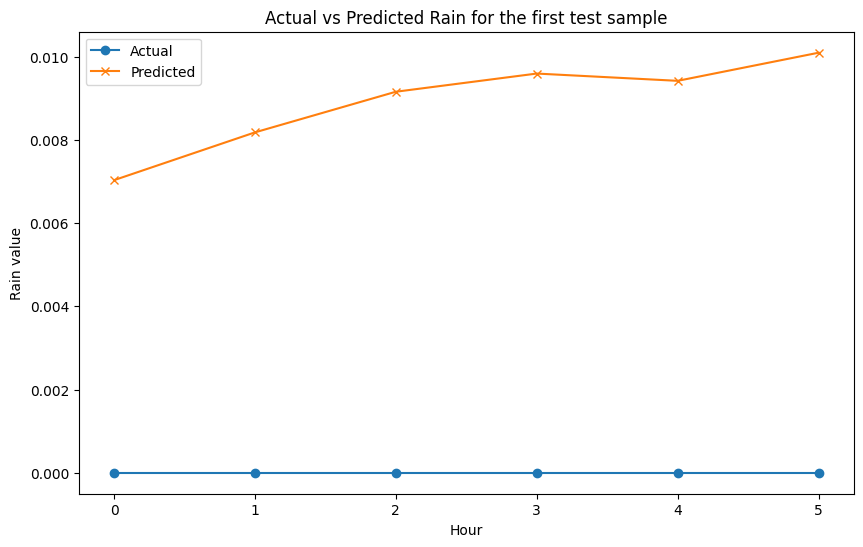

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = final_model.predict(X_test)
mse_test = mean_squared_error(y_test.flatten(), y_pred.flatten())
mae_test = mean_absolute_error(y_test.flatten(), y_pred.flatten())
r2_test = r2_score(y_test.flatten(), y_pred.flatten())

print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R2:", r2_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred[0], marker='x', label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample')
plt.legend()
plt.show()


XGB Test MSE: 0.0009023850527199618
XGB Test MAE: 0.010273487763668893
XGB Test R2: -0.02360820988829815


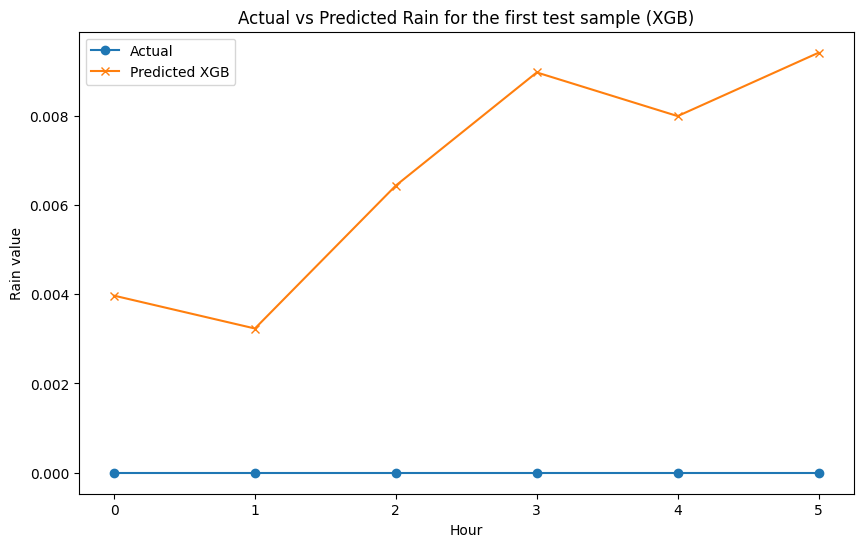

In [24]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten X_train và X_test từ (samples, input_steps, features) sang (samples, input_steps*features)
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Khởi tạo mô hình XGB cho bài toán multi-output
xgb_reg = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
xgb_reg.fit(X_train_xgb, y_train)

# Dự đoán trên tập test với XGB
y_pred_xgb = xgb_reg.predict(X_test_xgb)

mse_xgb = mean_squared_error(y_test.flatten(), y_pred_xgb.flatten())
mae_xgb = mean_absolute_error(y_test.flatten(), y_pred_xgb.flatten())
r2_xgb = r2_score(y_test.flatten(), y_pred_xgb.flatten())

print("XGB Test MSE:", mse_xgb)
print("XGB Test MAE:", mae_xgb)
print("XGB Test R2:", r2_xgb)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred_xgb[0], marker='x', label='Predicted XGB')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample (XGB)')
plt.legend()
plt.show()


Ensemble Test MSE: 0.0008401431526881982
Ensemble Test MAE: 0.010038847357369882
Ensemble Test R2: 0.04699504276922506


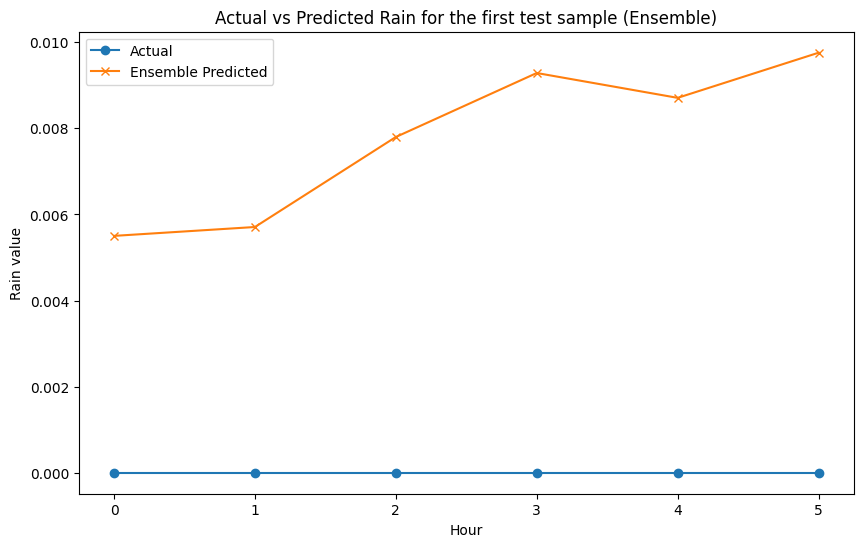

In [25]:
# Giả sử y_pred là dự đoán từ LSTM và y_pred_xgb là dự đoán từ XGB đã có
y_pred_ensemble = (y_pred + y_pred_xgb) / 2

# Tính các chỉ số cho dự đoán kết hợp
mse_ensemble = mean_squared_error(y_test.flatten(), y_pred_ensemble.flatten())
mae_ensemble = mean_absolute_error(y_test.flatten(), y_pred_ensemble.flatten())
r2_ensemble = r2_score(y_test.flatten(), y_pred_ensemble.flatten())

print("Ensemble Test MSE:", mse_ensemble)
print("Ensemble Test MAE:", mae_ensemble)
print("Ensemble Test R2:", r2_ensemble)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred_ensemble[0], marker='x', label='Ensemble Predicted')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample (Ensemble)')
plt.legend()
plt.show()
